## VAE Demo

In this notebook, we train a variational autoencoder on a two dimensional community and save the model parameters. 

We begin by importing numerical and deep learning libraries:

In [1]:
# We begin by importing the essentials
import numpy as np
import matplotlib.pyplot as plt

# We also setup torch for later usage.
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torch.nn import functional as F

from sklearn.model_selection import train_test_split 

# Configure GPU if available
if torch.cuda.is_available():
    # device = "cuda:0"
    
    device = "cuda:0"
else:
    device = "cpu"

display(device)

'cuda:0'

### Prepare Dataset

Now we will import in our dataset of interest. To consider other 2D or higher dimensional datasets such as chaotic, simply adjust the PATH variable below. Note that the dimensionalities of the encoder and decoders might need to be manually adjusted in the `SimpleVAE.py` model to ensure compatability of encoding steps and the input time series length. 

In [2]:
PATH = "./saved_sims/demo_2_member.npy"
X = np.load(PATH)

# Normalize the datasets to 0-1 and then split into train/test partitions. 
X = (X - X.min())/(X.max() - X.min())
X_train, X_test = train_test_split(X, test_size = 0.25, random_state = 42)

# Print the dimensions of the new training and testing set. 
print(X_train.shape)
print(X_test.shape)

(1875, 2, 30)
(625, 2, 30)


### Train VAE

As before, we now define a training function for our VAE. This is identical to the previous training functions except now we include a KL divergence loss to regularize the latent distribution of dynamics. 

First we import the model and define hyperparameters:

In [3]:
# Import model
from models.SimpleVAE import SimpleVAE

In [4]:
hp = {
    "kernel_size": 3,
    "embedding_dimension": 2,
    "lr" : 1e-3,
    "weight_decay" : 0,
    "epochs": 25000,
    "batch_size": 4800,
    "alpha": 1e-3,
    "depth": 3,
    "in":2,
    "gamma":0.0
}

Next we define the training functions:

In [5]:
def train(model, hp, data_loader, debug = False):

    # Store the losses per epoch
    running_losses = []
    
    # Configure optimizer and scheduler.
    optimizer = torch.optim.Adam(model.parameters(), lr=hp["lr"], weight_decay= hp["weight_decay"])
    
    # Outerloop will iterate through epochs. tqdm function trange provides progressbar
    for i in trange(hp["epochs"]):
        
        
        epoch_loss = 0 
        # Inner loop iterates through batches
        for batch in data_loader:

            # Transfer the batch to the GPU
            batch = batch.to(device)

            if debug:
                print("BATCH SHAPE: ")
                print(batch.shape)

            # Zero gradient
            optimizer.zero_grad()

            # Perform forward pass
            pred, code, mu, log_var = model(batch)

            # Uncomment to verify model prediction shape
            if debug:
                print("PREDI SHAPE: ")
                print(batch.shape)

            # Compute reconstruction loss
            batch_loss = SimpleVAE.vae_loss(pred, batch, mu, log_var, hp["alpha"])

            if debug:
                print(batch_loss)

            # Compute gradient
            batch_loss.backward()

            # Take step
            optimizer.step()

            # Append to running epoch loss
            epoch_loss += batch_loss

        # Keep running track of losses
        if i % 500 == 0:
            print(f"Epoch [{i}]: " + str(epoch_loss))
    
        running_losses.append(epoch_loss)

    return model, running_losses

Now we will setup the dataloader and transfer to GPU:

In [6]:
X_train = torch.Tensor(X_train).to(device).double()
train_loader = DataLoader(X_train, batch_size = hp["batch_size"])

And similarly setup the model:

In [7]:
model = SimpleVAE(hp)
model.double()
model.to(device);

And lastly we train:

In [8]:
trained_model, running_losses = train(model, hp, train_loader, False)

  0%|          | 0/25000 [00:00<?, ?it/s]

Epoch [0]: tensor(0.5694, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [500]: tensor(0.0135, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [1000]: tensor(0.0043, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [1500]: tensor(0.0033, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [2000]: tensor(0.0029, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [2500]: tensor(0.0029, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [3000]: tensor(0.0029, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [3500]: tensor(0.0029, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [4000]: tensor(0.0028, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [4500]: tensor(0.0028, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch [5000]: tensor(0.0028, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Epo

Plot the errors vs epochs:

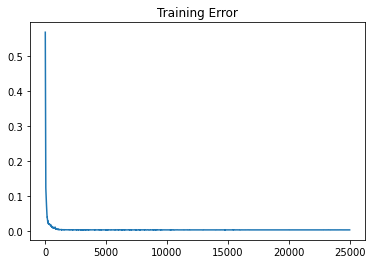

In [9]:
plt.plot(torch.Tensor(running_losses).cpu())
plt.title("Training Error")
plt.show()

## Analyze Results 

Now we look at the distribution of the latent space.  

In [10]:
# Compute reconstructions and latent embeddings of the dataset
X_recon, latents, _, _ = trained_model(X_train)
X_recon = X_recon.detach()

In [11]:
# Let's pick 100 curves at random and plot them for comparsion. This is a more reasonable number to just visually analyze. 
np.random.seed(42)
selected = np.random.randint(X_train.shape[0],  size = 250, )
selected;
X_train.shape

torch.Size([1875, 2, 30])

First we can plot the distribution of reconstructed training curves:

<ipython-input-12-321ee1f38f0b>:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  ax1.scatter(X_train[selected, 0, 0].cpu().T, X_train[selected, 1, 0].cpu().T,  c = "w", edgecolor = "b", zorder = 3)


torch.Size([1875, 2])


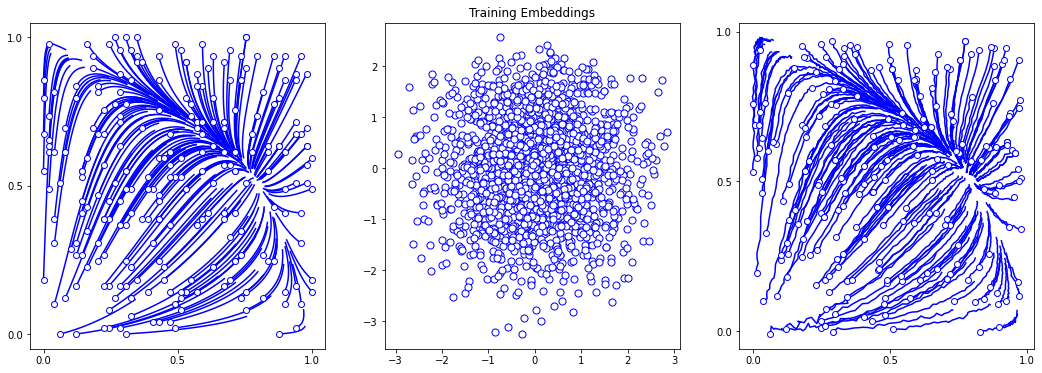

In [12]:
# Now for training data
import seaborn as sns

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (18, 6))

ax1.locator_params(axis='x', nbins=3)
ax1.locator_params(axis= 'y', nbins=3)
ax1.plot(X_train[selected, 0, :].cpu().T, X_train[selected, 1, :].cpu().T,  c = "b")
ax1.scatter(X_train[selected, 0, 0].cpu().T, X_train[selected, 1, 0].cpu().T,  c = "w", edgecolor = "b", zorder = 3)


print(latents.shape)
x = latents[:, 0].cpu().detach().T
y = latents[:, 1].cpu().detach().T

ax2.scatter(x,y, s = 50, c = "w", edgecolor = "b")


ax2.set_title("Training Embeddings")
ax3.locator_params(axis='x', nbins=3)
ax3.locator_params(axis= 'y', nbins=3)
ax3.plot(X_recon[selected, 0, :].cpu().T, X_recon[selected, 1, :].cpu().T,  c = "b")
ax3.scatter(X_recon[selected, 0, 0].cpu().T, X_recon[selected, 1, 0].cpu().T, c = "w", edgecolor = "b", zorder = 3)
plt.show()

Additionally we can interpolate points within the latent space to show the system generates a  map from the latent distribution into phase space:

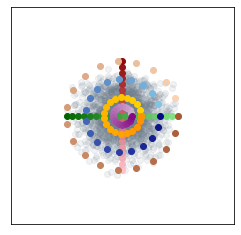

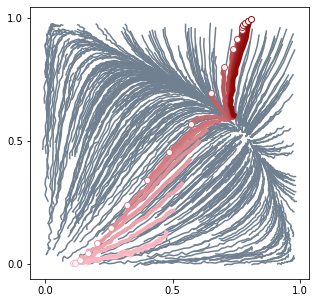

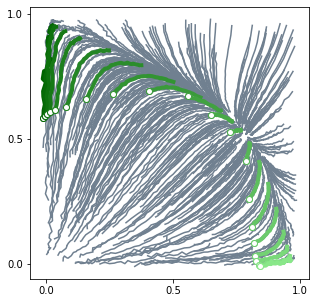

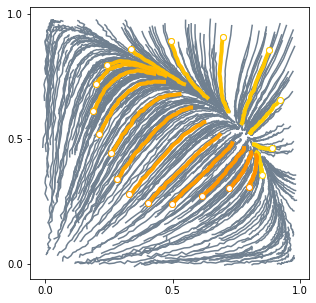

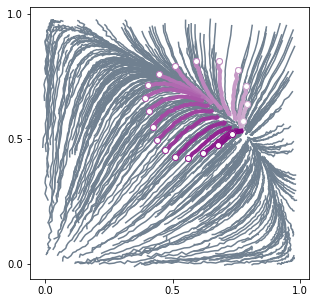

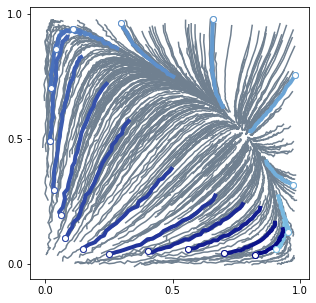

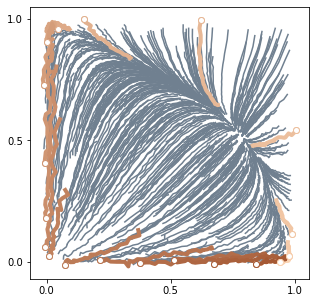

In [13]:
import matplotlib as mpl

plt.figure(figsize = (4,4))
plt.scatter(x, y, zorder = 1, alpha = 0.1, c = "slategrey" )

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='pink' #blue
c2='darkred' #green

pi = 3.1415
n = 20 

x_latents = torch.mean(x) + 0*torch.std(x)*np.linspace(-3,3, n)
y_latents = torch.mean(y) + 1*torch.std(y)*np.linspace(-3,3, n)

x_latents_2 = torch.mean(x) + 1*torch.std(x)*np.linspace(-3,3, n)
y_latents_2 = torch.mean(y) + 0*torch.std(y)*np.linspace(-3,3, n)

x_latents_3 = torch.mean(x) + 1*torch.std(x)*np.cos(np.linspace(0,2*pi,n))
y_latents_3 = torch.mean(y) + 1*torch.std(y)*np.sin(np.linspace(0,2*pi,n))

x_latents_4 = torch.mean(x) + 0.5*torch.std(x)*np.cos(np.linspace(0,2*pi,n))
y_latents_4 = torch.mean(y) + 0.5*torch.std(y)*np.sin(np.linspace(0,2*pi,n))


x_latents_5 = torch.mean(x) + 2*torch.std(x)*np.cos(np.linspace(0,2*pi,n))
y_latents_5 = torch.mean(y) + 2*torch.std(y)*np.sin(np.linspace(0,2*pi,n))

x_latents_6 = torch.mean(x) + 3*torch.std(x)*np.cos(np.linspace(0,2*pi,n))
y_latents_6 = torch.mean(y) + 3*torch.std(y)*np.sin(np.linspace(0,2*pi,n))

for i in range(x_latents.shape[0]):
    plt.scatter(x_latents[i], y_latents[i], color=colorFader(c1,c2,i/n))
    
c1='darkgreen' #blue
c2='lightgreen' #green

for i in range(x_latents.shape[0]):
    plt.scatter(x_latents_2[i], y_latents_2[i], color=colorFader(c1,c2,i/n))
    
c1='gold' #blue
c2='darkorange' #green

for i in range(x_latents.shape[0]):
    plt.scatter(x_latents_3[i], y_latents_3[i], color=colorFader(c1,c2,i/n))
    

c1='thistle' #blue
c2='purple' #green
    
for i in range(x_latents.shape[0]):
    plt.scatter(x_latents_4[i], y_latents_4[i], color=colorFader(c1,c2,i/n))
    
c1='skyblue' #blue
c2='navy' #green
    
for i in range(x_latents.shape[0]):
    plt.scatter(x_latents_5[i], y_latents_5[i], color=colorFader(c1,c2,i/n))
    
c1='peachpuff' #blue
c2='sienna' #green
    
for i in range(x_latents.shape[0]):
    plt.scatter(x_latents_6[i], y_latents_6[i], color=colorFader(c1,c2,i/n))
    
# plt.scatter(x_latents_3, y_latents_3, c = "g")


plt.xticks([])
plt.yticks([])
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.show()

plt.figure(figsize = (5,5))
plt.locator_params(axis='x', nbins=3)
plt.locator_params(axis= 'y', nbins=3)
plt.plot(X_recon[1:500, 0, :].cpu().T, X_recon[1:500, 1, :].cpu().T,  c = "slategrey")
# plt.scatter(X_recon[:, 0, 0].cpu().T, X_recon[:, 1, 0].cpu().T, c = "w", edgecolor = "b", zorder = 3)


X_latents = torch.Tensor(np.vstack((x_latents,y_latents)).T).to(device).double()
sample_recon = trained_model.decoder( trained_model.linear2(X_latents).view(n, 16, -1)).cpu().detach()

c1='pink' #blue
c2='darkred' #green
for i in range(x_latents.shape[0]):
    plt.plot(sample_recon[i, 0, :].cpu().T, sample_recon[i, 1, :].cpu().T, c =colorFader(c1,c2,i/n), zorder = 3, lw = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w", edgecolor =colorFader(c1,c2,i/n), zorder = 4)
plt.show()

plt.figure(figsize = (5,5))
plt.locator_params(axis='x', nbins=3)
plt.locator_params(axis= 'y', nbins=3)

plt.plot(X_recon[1:500, 0, :].cpu().T, X_recon[1:500, 1, :].cpu().T,  c = "slategrey")
X_latents = torch.Tensor(np.vstack((x_latents_2,y_latents_2)).T).to(device).double()
sample_recon = trained_model.decoder( trained_model.linear2(X_latents).view(n, 16, -1)).cpu().detach()

c1='darkgreen' #blue
c2='lightgreen' #green
for i in range(x_latents.shape[0]):
    plt.plot(sample_recon[i, 0, :].cpu().T, sample_recon[i, 1, :].cpu().T, c =colorFader(c1,c2,i/n), zorder = 3, lw = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w", edgecolor =colorFader(c1,c2,i/n), zorder = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w",edgecolor =colorFader(c1,c2,i/n), zorder = 4)
plt.show()

plt.figure(figsize = (5,5))
plt.locator_params(axis='x', nbins=3)
plt.locator_params(axis= 'y', nbins=3)

plt.plot(X_recon[1:500, 0, :].cpu().T, X_recon[1:500, 1, :].cpu().T,  c = "slategrey")

X_latents = torch.Tensor(np.vstack((x_latents_3,y_latents_3)).T).to(device).double()
sample_recon = trained_model.decoder( trained_model.linear2(X_latents).view(n, 16, -1)).cpu().detach()
    
c1='gold' #blue
c2='darkorange' #green
for i in range(x_latents.shape[0]):
    plt.plot(sample_recon[i, 0, :].cpu().T, sample_recon[i, 1, :].cpu().T, c =colorFader(c1,c2,i/n), zorder = 3, lw = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w", edgecolor =colorFader(c1,c2,i/n), zorder = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w",edgecolor =colorFader(c1,c2,i/n), zorder = 4)
plt.show()

plt.figure(figsize = (5,5))
plt.locator_params(axis='x', nbins=3)
plt.locator_params(axis= 'y', nbins=3)

plt.plot(X_recon[1:500, 0, :].cpu().T, X_recon[1:500, 1, :].cpu().T,  c = "slategrey")

X_latents = torch.Tensor(np.vstack((x_latents_4,y_latents_4)).T).to(device).double()
sample_recon = trained_model.decoder( trained_model.linear2(X_latents).view(n, 16, -1)).cpu().detach()

c1='thistle' #blue
c2='purple' #green
for i in range(x_latents.shape[0]):
    plt.plot(sample_recon[i, 0, :].cpu().T, sample_recon[i, 1, :].cpu().T, c =colorFader(c1,c2,i/n), zorder = 3, lw = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w", edgecolor =colorFader(c1,c2,i/n), zorder = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w",edgecolor =colorFader(c1,c2,i/n), zorder = 4)
plt.show()


plt.figure(figsize = (5,5))
plt.locator_params(axis='x', nbins=3)
plt.locator_params(axis= 'y', nbins=3)

plt.plot(X_recon[1:500, 0, :].cpu().T, X_recon[1:500, 1, :].cpu().T,  c = "slategrey")

X_latents = torch.Tensor(np.vstack((x_latents_5,y_latents_5)).T).to(device).double()
sample_recon = trained_model.decoder( trained_model.linear2(X_latents).view(n, 16, -1)).cpu().detach()

c1='skyblue' #blue
c2='navy' #green
for i in range(x_latents.shape[0]):
    plt.plot(sample_recon[i, 0, :].cpu().T, sample_recon[i, 1, :].cpu().T, c =colorFader(c1,c2,i/n), zorder = 3, lw = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w", edgecolor =colorFader(c1,c2,i/n), zorder = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w",edgecolor =colorFader(c1,c2,i/n), zorder = 4)
plt.show()



plt.figure(figsize = (5,5))
plt.locator_params(axis='x', nbins=3)
plt.locator_params(axis= 'y', nbins=3)

plt.plot(X_recon[1:500, 0, :].cpu().T, X_recon[1:500, 1, :].cpu().T,  c = "slategrey")

X_latents = torch.Tensor(np.vstack((x_latents_6,y_latents_6)).T).to(device).double()
sample_recon = trained_model.decoder( trained_model.linear2(X_latents).view(n, 16, -1)).cpu().detach()

c1='peachpuff' #blue
c2='sienna' #green
for i in range(x_latents.shape[0]):
    plt.plot(sample_recon[i, 0, :].cpu().T, sample_recon[i, 1, :].cpu().T, c =colorFader(c1,c2,i/n), zorder = 3, lw = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w", edgecolor =colorFader(c1,c2,i/n), zorder = 4)
    plt.scatter(sample_recon[i, 0, 0].cpu().T, sample_recon[i, 1, 0].cpu().T, c = "w",edgecolor =colorFader(c1,c2,i/n), zorder = 4)
plt.show()

And lastly we analyze how well the VAE performs on testing set partition: 

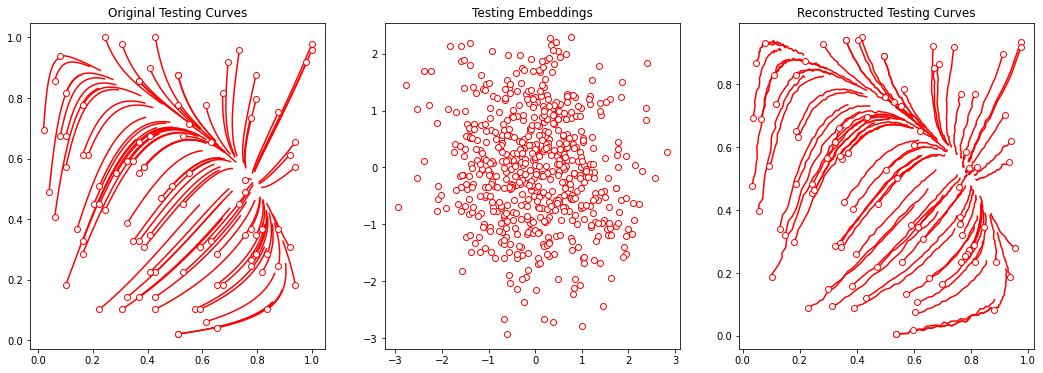

In [16]:
# Now for testing data
X_test = torch.Tensor(X_test)
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (18, 6))

selected = np.random.randint(X_test.shape[0], size = 100,)
ax1.plot(X_test[selected, 0, :].T.cpu(), X_test[selected, 1, :].T.cpu(), c = "r")
ax1.scatter(X_test[selected, 0, 0].T.cpu(), X_test[selected, 1, 0].T.cpu(), c = "w", edgecolor = "r", zorder = 3)
ax1.set_title("Original Testing Curves")

X_test_recon, latents, _, _ = trained_model(torch.Tensor(X_test).to(device).double())
X_test_recon = X_test_recon.cpu().detach()

# latents = (latents - latents.min())/(latents.max() - latents.min())
ax2.scatter(latents[:, 0].cpu().detach().numpy(), latents[:, 1].cpu().detach().T, c = "w", edgecolors = "r")
ax2.set_title("Testing Embeddings")

ax3.plot(X_test_recon[selected, 0, :].T, X_test_recon[selected, 1, :].T, c = "r")
ax3.scatter(X_test_recon[selected, 0, 0].T, X_test_recon[selected, 1, 0].T, c = "w", edgecolor = "r", zorder = 3)
ax3.set_title("Reconstructed Testing Curves")
plt.show()

Lastly save the model:

In [19]:
torch.save(trained_model, "./saved_params/example.pt")